<a href="https://colab.research.google.com/github/whale1510/movie_genre_multilabel_classification/blob/main/multilabel_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ BERT 모델을 기반으로 하는 멀티 레이블 영화 장르 분류기
- [수행기능] : 영화의 텍스트 데이터를 입력받아 해당 영화가 어떤 장르들을 가지고 있는 지를 분류. 이때, 분류는 단일 클래스 분류가 아닌 다중 레이블 형태.
- [데이터] : 레포지토리의 raw_data 파일
- [사용모델] : 허깅페이스의 bert 모델

# 라이브러리 및 프레임워크 준비


In [ ]:
!pip install evaluate
!pip install datasets
!pip install transformers
!pip install accelerate -U
!pip install rouge_score
!pip install koreanize_matplotlib
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=1009ff6ab31b0a3d3454a0bf7ee3ac9a2e71927352f1a1f26d19b083cc817591
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 51.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'
import re
from konlpy.tag import Okt
from gensim.models import Word2Vec

In [ ]:
#허깅페이스에서 transformer BERT 모델 가져옴
from tqdm import tqdm
warnings.filterwarnings("ignore")

from sklearn import metrics

import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, AutoConfig

random_seed = 1770001525

# 데이터 로딩

In [ ]:
#특정 년도간 모은 raw 데이터
df = pd.read_csv('./raw_data.csv')

In [ ]:
#null 값 제거 / 결측치 제거
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.dropna(axis=0, how = 'any', inplace = True)
df = df.reset_index(drop=True)

In [ ]:
#제거된 데이터 프레임 확인
df

,영화명,장르,시놉시스,SF,가족,공연,공포(호러),다큐멘터리,드라마,로맨스,...,범죄,사극,서부극(웨스턴),스릴러,애니메이션,액션,어드벤처,전쟁,코미디,판타지
0,밀수,액션,열길 물속은 알아도 한길 사람 속은 모른다! 평화롭던 바닷가 마을 군천에 화학 공장...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,금지된 사랑,드라마,스티븐(Stephane: 다니엘 오떼이유 분)과 맥심(Maxime: 앙드레 뒤솔리에...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,천박사 퇴마 연구소: 설경의 비밀,"판타지, 액션",대대로 마을을 지켜 온 당주집 장손이지만 정작 귀신은 믿지 않는 가짜 퇴마사 ‘천박...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,싱글 인 서울,"멜로, 로맨스, 코미디","“나한테 딱 맞는 사람은 나밖에 없어, 싱글이 답이다!” 혼자 걷기, 혼자 쉬기, ...",0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,뉴 노멀,스릴러,"새로운 시대가 열렸다. 오늘, 당신의 공포는 일상이 된다.",0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18236,1724 기방난동사건,"사극, 액션, 코미디","경종 집권 말기, 노론과 소론간의 당쟁이 절정을 이루며 구름이 드리워진 궁궐 앞! ...",0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
18237,스페어,액션,가진 건 날쌘 다리와 주먹 밖에 없는 광태(임준일)는 사채업자 명수(김수현)의 부하...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18238,철권,"액션, 판타지, SF","젊은 사장인 카자마가 거느리는“미시마 재벌”과, 그의 아버지인 미시마 일파가 실권을...",1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
18239,벤자민 프로젝트,"액션, 코미디",마이애미의 잘 나가는 사립탐정이자 현상금 사냥꾼인'버쿰 잭슨'(아이스 큐브)의 이번...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
#장르 데이터를 분류해서 계산이 쉽게 형태를 바꿈
df['장르'] = df['장르'].str.replace(',', ' ')
df['장르'] = df['장르'].str.replace('/', ' ')

In [ ]:
#사용할 전체 장르가 몇개인지를 확인하는 코드
genres = []

for genre_str in df['장르']:
    genres.extend(genre_str.split())

unique = set(genres)
num = len(unique)

print(f'장르 수: {num}')

장르 수: 20


In [ ]:
#전체 데이터를 다 쓰지 않고, 1만개의 데이터만 사용. 이미 raw가 샘플링된 상태임.
df = df[:10000]

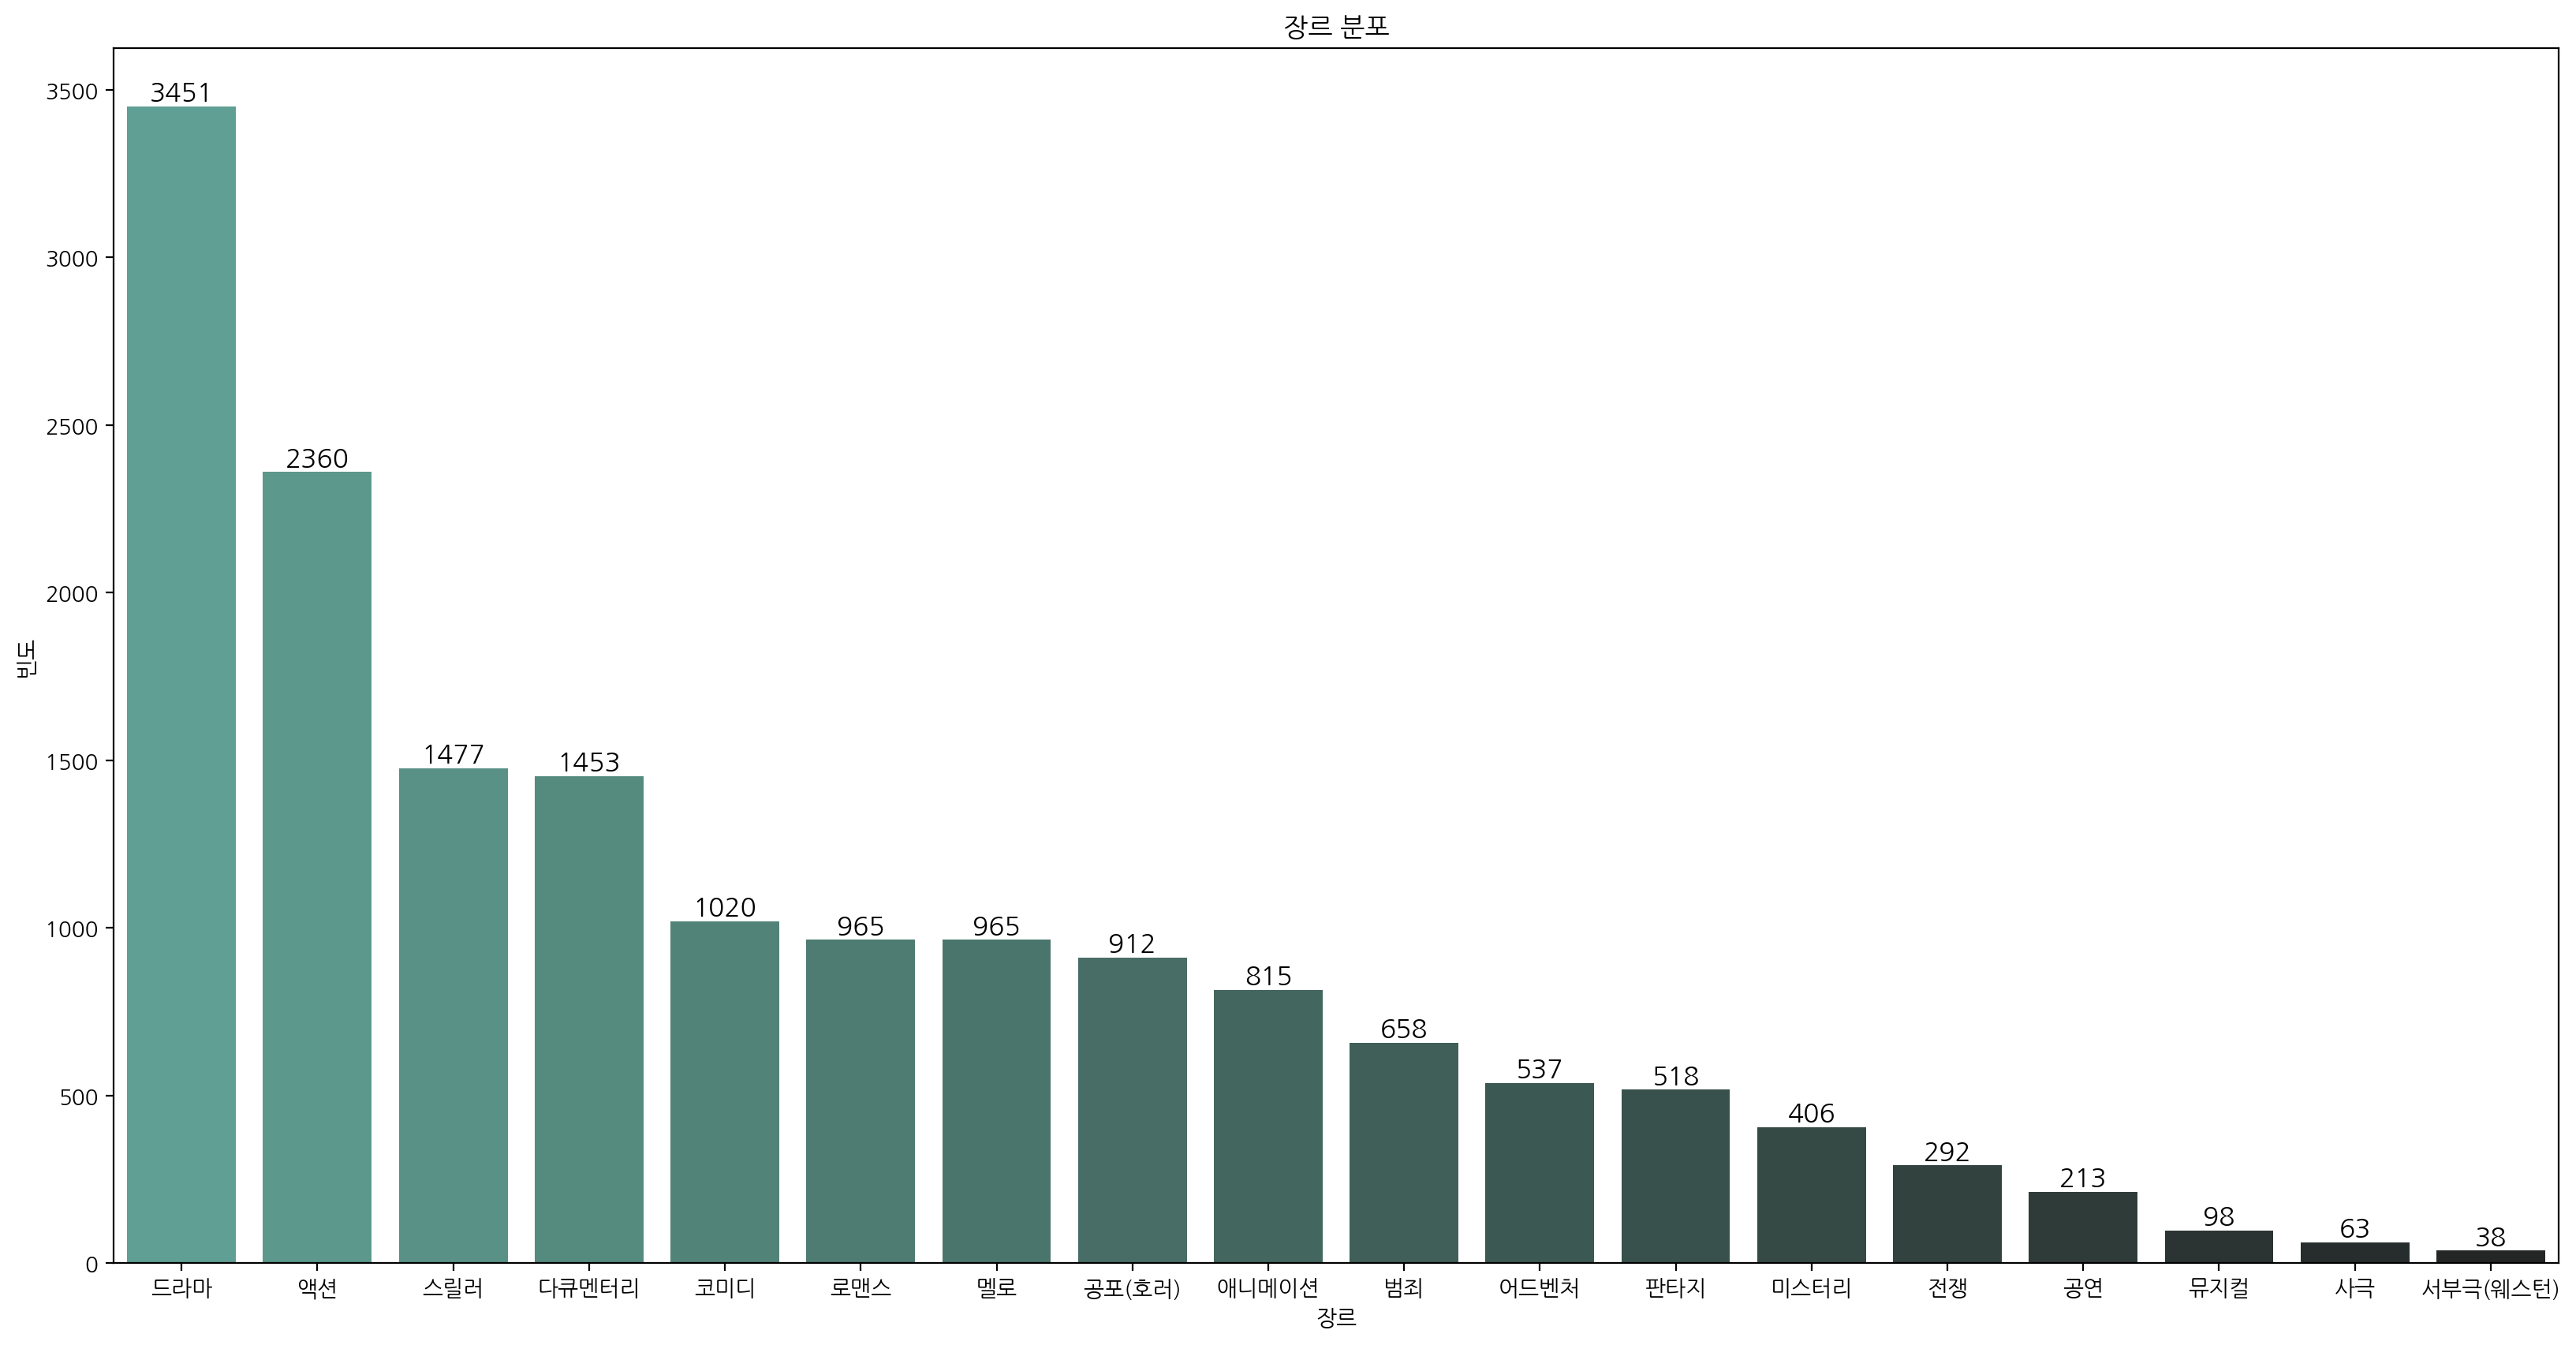

In [ ]:
#장르별 데이터의 분포를 알아봄
#데이터의 크기에는 큰 차이가 있으나, 실제로는 결과가 몇개의 장르가 혼합된 벡터로 나오기 때문에 데이터의 불균형이 성능에 큰 영향을 주지 않음.
#때문에 데이터 크기를 따로 처리하지는 않음.
genre_counts = df.iloc[:, -18:].sum()
genre_counts = genre_counts.sort_values(ascending = False)

plt.figure(figsize = (20, 10))
ax = sns.barplot(x=genre_counts.index, y = genre_counts.values, palette="dark:#5A9_r")

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('장르 분포')
plt.xlabel('장르')
plt.ylabel('빈도')
plt.show()

In [ ]:
#정답지 label을 생성하기 위하여,
# 여러 개의 label column을 하나의 list로 통합
df["list"] = df[df.columns[3:]].values.tolist()
new_df = df[["시놉시스", "list"]].copy()
new_df.head()

,시놉시스,list
0,열길 물속은 알아도 한길 사람 속은 모른다! 평화롭던 바닷가 마을 군천에 화학 공장...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,스티븐(Stephane: 다니엘 오떼이유 분)과 맥심(Maxime: 앙드레 뒤솔리에...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,대대로 마을을 지켜 온 당주집 장손이지만 정작 귀신은 믿지 않는 가짜 퇴마사 ‘천박...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"“나한테 딱 맞는 사람은 나밖에 없어, 싱글이 답이다!” 혼자 걷기, 혼자 쉬기, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,"새로운 시대가 열렸다. 오늘, 당신의 공포는 일상이 된다.","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


# pre-processing

In [ ]:
#loading tokenizer
model_checkpoint = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
# custom dataset class 정의
# 텍스터를 로딩 가능한 데이터로 변경하기 위한 작업.
# tokenizer를 거치면 token_type_ids를 통해 앞 시퀀스인지, 뒤 시퀀스인지 구별 가능

class text_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer # 원본 텍스트를 tokenize할 tokenizer
        self.data = dataframe # 원본 데이터
        self.comment_text = dataframe["시놉시스"]
        self.targets = self.data["list"]
        self.max_len = max_len # tokenizer의 max length argument로 사용

    def __getitem__(self, idx):
        comment_text = str(self.comment_text[idx])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens = True,
            max_length = self.max_len, # input_max_length
            padding = "max_length", # padding 할 길이
            truncation = True, # truncation 여부
            return_token_type_ids = True, # token_type_ids: 첫 번째 시퀀스(0)인지, 두 번째 시퀀스(1)인지 표시
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"] #padding을 데이터 처리 하지 않기 위한
        token_type_ids = inputs["token_type_ids"]

        return {
            "ids": torch.tensor(ids, dtype = torch.long),
            "mask": torch.tensor(mask, dtype = torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype = torch.long),
            "targets": torch.tensor(self.targets[idx], dtype = torch.float)
        }

    def __len__(self):
        return len(self.comment_text)

In [ ]:
train_size = 0.8 #훈련 데이터 사이즈 결정.
train_dataset = new_df.sample(frac = train_size, random_state = random_seed).reset_index(drop = True)
test_dataset = new_df.drop(train_dataset.index).reset_index(drop = True)

max_len = 300 #토큰화에 사용될 최대 허용 길이

trainDS = text_Dataset(train_dataset, tokenizer, max_len)
testDS = text_Dataset(test_dataset, tokenizer, max_len)

In [ ]:
trainDL = DataLoader(trainDS, batch_size = 16, shuffle = True) # num_workers param also available
testDL = DataLoader(testDS, batch_size = 16, shuffle = True)

In [ ]:
#데이터 확인
trainDS[0]
#id는 실제 데이터, 이중 0의 값은 패딩 값. mask는 패딩 값의 구분

{'ids': tensor([    2,  1826,  2256,  2275,  2079,  1268,  5019,  2507,  2414,  1282,
          2057,  2052,  2259,  3912,  2440,  1537,    16,   804,  2255,  2522,
          4273, 31302,  3627, 12749,  1808,  2170,  1458,  2062,    18,  3719,
          3821,  2259,  3638,  2079,  5512,  4114,  3883,  7285, 12749,  3997,
          2031,  2145,  4273,  2085,  1295,  1513, 16818, 15667,  2062,    18,
          3699,  3821,  2079, 10499,  1697,  2170,  4356, 28674,    18,  3995,
            16,  7844,  2079,   918,  3656,  1539,  2073,  3811,  1233,  3007,
          2073, 12749,  3997,  2138,  1642,  2279,  2370,  3605,    18,  3633,
          2440,  1943,  3771,  2259,   636,  2031,  2069,  3690,  4026,   636,
          7285,  3638,  2069,  3627,  1902,  2414,  1237,  2079,  4025,  7285,
          3711,  3731,  2031,  2069,   731,  2886, 18246, 23248,    18,    63,
          1545, 21768,  2124, 12216,  3854,  2062,  2381, 16516,  2021,    64,
             3,     0,     0,     0,     0,  

In [ ]:
#배치 확인
batch = next(iter(trainDL))
batch

{'ids': tensor([[    2,  5959,  2079,  ...,     0,     0,     0],
         [    2,  7449,  2170,  ...,     0,     0,     0],
         [    2, 14000,  2440,  ...,     0,     0,     0],
         ...,
         [    2,  3890,  2052,  ...,     0,     0,     0],
         [    2,  3741, 27135,  ...,     0,     0,     0],
         [    2,  5091,  2522,  ...,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 1.],
         [0., 0., 0., 0., 1., 0.,

# 모델링

In [ ]:
torch.cuda.is_available()

True

In [ ]:
#분류모델 정의
class Text_Classifier(nn.Module):
    def __init__(self, model_checkpoint):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_checkpoint) #미리 훈련된  BERT 모델을 불러옴
        self.dropout = nn.Dropout(0.3)
        self.clf = nn.Linear(self.transformer.config.hidden_size, 20) # transformer layer의 hidden size를 최종 class 개수인 20으로 압축

    def forward(self, ids, mask, token_type_ids): #순전파 정의
        _, pooled_output = self.transformer(input_ids = ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict = False)
        out = self.dropout(pooled_output)
        out = self.clf(out)

        return out

device = torch.device("cuda:0") # torch.device("cuda:1" if torch.cuda.is_available else "cpu")

model = Text_Classifier(model_checkpoint)
model = model.to(device)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

# train & validation

In [ ]:
learning_rate = 1e-05 #학습률
num_epochs = 50 #에포크 수

#손실함수 정의
def loss_fn(preds, targets): return nn.BCEWithLogitsLoss()(preds, targets)
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

 #훈련과정
def train(epoch):
    model.train()
    total_loss = 0
    for _, batch in enumerate(trainDL):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {total_loss}")

'\n# multiclass classification task 에서 어떤 loss function을 사용할지 고민해보세요:\n# e.g. Binary Cross Entropy, Cross Entropy, L2, L1 etc.\ndef loss_fn(preds, targets): return nn.CrossEntropyLoss()(preds, targets)\n# 적절한 optimizer를 선택하고 argument를 적절하게 부여하세요.\noptimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)\n'

In [ ]:
for epoch in tqdm(range(num_epochs)):
    train(epoch)

  2%|▏         | 1/50 [02:12<1:47:51, 132.07s/it]

Epoch: 0, Loss: 131.48200279474258


  4%|▍         | 2/50 [04:21<1:44:11, 130.24s/it]

Epoch: 1, Loss: 92.75870985537767


  6%|▌         | 3/50 [06:30<1:41:36, 129.71s/it]

Epoch: 2, Loss: 79.5909660756588


  8%|▊         | 4/50 [08:39<1:39:12, 129.40s/it]

Epoch: 3, Loss: 69.97495475411415


 10%|█         | 5/50 [10:47<1:36:55, 129.24s/it]

Epoch: 4, Loss: 62.303855933249


 12%|█▏        | 6/50 [12:56<1:34:39, 129.08s/it]

Epoch: 5, Loss: 55.21440526843071


 14%|█▍        | 7/50 [15:05<1:32:28, 129.05s/it]

Epoch: 6, Loss: 49.09746530652046


 16%|█▌        | 8/50 [17:14<1:30:14, 128.92s/it]

Epoch: 7, Loss: 43.33863954618573


 18%|█▊        | 9/50 [19:22<1:28:01, 128.82s/it]

Epoch: 8, Loss: 38.679754965007305


 20%|██        | 10/50 [21:32<1:25:59, 128.98s/it]

Epoch: 9, Loss: 34.340883538126945


 22%|██▏       | 11/50 [23:41<1:23:50, 128.98s/it]

Epoch: 10, Loss: 30.71820180118084


 24%|██▍       | 12/50 [25:50<1:21:39, 128.94s/it]

Epoch: 11, Loss: 26.956282950937748


 26%|██▌       | 13/50 [27:59<1:19:30, 128.93s/it]

Epoch: 12, Loss: 24.04360494017601


 28%|██▊       | 14/50 [30:07<1:17:17, 128.82s/it]

Epoch: 13, Loss: 21.046341028995812


 30%|███       | 15/50 [32:16<1:15:07, 128.79s/it]

Epoch: 14, Loss: 18.770887131802738


 32%|███▏      | 16/50 [34:25<1:12:59, 128.81s/it]

Epoch: 15, Loss: 16.31783887371421


 34%|███▍      | 17/50 [36:33<1:10:47, 128.72s/it]

Epoch: 16, Loss: 14.703652056865394


 36%|███▌      | 18/50 [38:42<1:08:37, 128.69s/it]

Epoch: 17, Loss: 13.458179414272308


 38%|███▊      | 19/50 [40:51<1:06:30, 128.73s/it]

Epoch: 18, Loss: 11.855998030398041


 40%|████      | 20/50 [42:59<1:04:21, 128.70s/it]

Epoch: 19, Loss: 10.634698975365609


 42%|████▏     | 21/50 [45:08<1:02:12, 128.69s/it]

Epoch: 20, Loss: 9.433589992113411


 44%|████▍     | 22/50 [47:17<1:00:06, 128.81s/it]

Epoch: 21, Loss: 8.611650601029396


 46%|████▌     | 23/50 [49:26<57:59, 128.87s/it]  

Epoch: 22, Loss: 7.710428217193112


 48%|████▊     | 24/50 [51:35<55:49, 128.83s/it]

Epoch: 23, Loss: 6.99456069781445


 50%|█████     | 25/50 [53:44<53:40, 128.84s/it]

Epoch: 24, Loss: 6.7503430128563195


 52%|█████▏    | 26/50 [55:53<51:32, 128.84s/it]

Epoch: 25, Loss: 6.187374045839533


 54%|█████▍    | 27/50 [58:01<49:22, 128.80s/it]

Epoch: 26, Loss: 5.8565633040852845


 56%|█████▌    | 28/50 [1:00:10<47:12, 128.76s/it]

Epoch: 27, Loss: 5.596068277489394


 58%|█████▊    | 29/50 [1:02:19<45:05, 128.82s/it]

Epoch: 28, Loss: 5.234963483409956


 60%|██████    | 30/50 [1:04:28<42:56, 128.83s/it]

Epoch: 29, Loss: 4.789142204914242


 62%|██████▏   | 31/50 [1:06:37<40:48, 128.85s/it]

Epoch: 30, Loss: 4.424392608460039


 64%|██████▍   | 32/50 [1:08:45<38:39, 128.86s/it]

Epoch: 31, Loss: 4.325004834448919


 66%|██████▌   | 33/50 [1:10:54<36:29, 128.82s/it]

Epoch: 32, Loss: 4.197482506860979


 68%|██████▊   | 34/50 [1:13:03<34:20, 128.79s/it]

Epoch: 33, Loss: 4.228124802932143


 70%|███████   | 35/50 [1:15:12<32:12, 128.82s/it]

Epoch: 34, Loss: 3.849593126331456


 72%|███████▏  | 36/50 [1:17:21<30:04, 128.89s/it]

Epoch: 35, Loss: 3.8336062093731016


 74%|███████▍  | 37/50 [1:19:30<27:54, 128.84s/it]

Epoch: 36, Loss: 3.4987482285359874


 76%|███████▌  | 38/50 [1:21:38<25:45, 128.80s/it]

Epoch: 37, Loss: 3.461530905624386


 78%|███████▊  | 39/50 [1:23:47<23:36, 128.76s/it]

Epoch: 38, Loss: 3.4858019874664024


 80%|████████  | 40/50 [1:25:56<21:27, 128.73s/it]

Epoch: 39, Loss: 3.1552989383926615


 82%|████████▏ | 41/50 [1:28:04<19:18, 128.70s/it]

Epoch: 40, Loss: 3.0499493499519303


 84%|████████▍ | 42/50 [1:30:13<17:09, 128.69s/it]

Epoch: 41, Loss: 3.1871695560985245


 86%|████████▌ | 43/50 [1:32:22<15:01, 128.74s/it]

Epoch: 42, Loss: 2.958498932013754


 88%|████████▊ | 44/50 [1:34:30<12:52, 128.71s/it]

Epoch: 43, Loss: 2.7445623059174977


 90%|█████████ | 45/50 [1:36:39<10:43, 128.65s/it]

Epoch: 44, Loss: 2.594720124907326


 92%|█████████▏| 46/50 [1:38:47<08:34, 128.61s/it]

Epoch: 45, Loss: 2.814408599631861


 94%|█████████▍| 47/50 [1:40:56<06:25, 128.54s/it]

Epoch: 46, Loss: 2.658189378271345


 96%|█████████▌| 48/50 [1:43:04<04:16, 128.49s/it]

Epoch: 47, Loss: 2.4939042227342725


 98%|█████████▊| 49/50 [1:45:13<02:08, 128.52s/it]

Epoch: 48, Loss: 2.285351741244085


100%|██████████| 50/50 [1:47:21<00:00, 128.84s/it]

Epoch: 49, Loss: 2.2722878577187657


In [ ]:
def validation():
    model.eval() #활성화되지 않은 계층을 위해서
    fin_targets=[] #실제레이블
    fin_outputs=[] #출력레이블
    with torch.no_grad():
        for _, data in enumerate(testDL): #배치단위로 데이터셋 가죠옴
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets #결과 반환

#결과

In [ ]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5 #기준세우기
accuracy = metrics.accuracy_score(targets, outputs)
# F1-micro는 각 data sample 별로 계산하여,
#빈도가 높은 label의 성능이 높으면 유리함
# F1-macro는 각 class 별로 계산하여,
#빈도가 낮은 label은 빈도가 높은 label과 같은 비중을 가짐
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.8685
F1 Score (Micro) = 0.9216695254431103
F1 Score (Macro) = 0.912911618233393


In [ ]:
#실제 아웃풋의 형태
outputs[4]

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False])

In [ ]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(targets, outputs))


              precision    recall  f1-score   support

           0       0.93      0.94      0.93        97
           1       0.98      0.89      0.93        55
           2       0.91      0.95      0.93        22
           3       0.92      0.98      0.95       191
           4       0.98      0.97      0.97       330
           5       0.92      0.94      0.93       683
           6       0.92      0.92      0.92       207
           7       0.92      0.92      0.92       207
           8       0.92      0.79      0.85        14
           9       0.80      0.88      0.84        90
          10       0.94      0.81      0.87       145
          11       1.00      0.79      0.88        14
          12       1.00      1.00      1.00         6
          13       0.90      0.93      0.92       338
          14       0.92      0.93      0.93       169
          15       0.94      0.94      0.94       425
          16       0.87      0.87      0.87       128
          17       0.89    

#실제 1개 데이터 운용

In [ ]:
#10002번째 데이터
print(test_text) #데이터 형태
print(label) #데이터의 정답지

10002    어릴 때 비무장지대인 금삼각으로 납치돼 한 마리의 개처럼 훈련을 받으면서 지옥 속에...
Name: 시놉시스, dtype: object
10002    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: list, dtype: object


In [ ]:
#전처리
test_text = test_text.str.cat(sep=' ')
test_input = tokenizer(test_text, padding=True, truncation=True, max_length=300, return_tensors="pt")

input_ids = test_input["input_ids"].to(device)
attention_mask = test_input["attention_mask"].to(device)
token_type_ids = test_input.get("token_type_ids").to(device) if "token_type_ids" in test_input else None
model.eval()

Text_Classifier(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
#예측
with torch.no_grad():
    outputs = model(input_ids, attention_mask, token_type_ids)
    outputs = outputs.cpu().numpy() >= 0.5
print(outputs[0])
label_result = pd.DataFrame(label).iloc[0]
print(label_result[0])
metrics.accuracy_score(label_result[0], outputs[0])

[False False False False False  True False False False False False False
 False False False  True False False False False]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


1.0